In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import segyio
import SegRead as s
import os
import sys
from seislab.src import segyrw 
from seislab.src import plot_seismic
from LAS import Converter
from scipy import signal
from scipy.signal import medfilt
import laspy
from sklearn.linear_model import LinearRegression
from docx import Document
from numpy.linalg import solve
from matplotlib.colors import Normalize
from laspy.file import File
%load_ext autoreload
%autoreload 2

# New Section

In [2]:
from seislab.src import segyrw 

directory = ''
filename = directory+'307_Stk_w1.sgy'
sys.path.append('seislab')

ss = s.Seg.SegReader()
ss.open(filename)
data = ss.get_data()
data = data.T


head = segyrw.read_header_segyio_full(filename)
dt = 2 # Дискретизация (считывать из хэдеров?)


Tdata=np.arange(0,np.shape(data)[0]*dt,dt)/1000  # вектор врмеен для сейсмики

In [3]:
from ipywidgets import widgets

cdp_min, cdp_max, time_min, time_max = [head['CDP_TRACE'].min(), head['CDP_TRACE'].max(), 0, dt * data.shape[0]]
time_step = dt
cdp_step = (cdp_max - cdp_min) // data.shape[1]
(cdp_min, cdp_max, cdp_step),  (time_min, time_max, time_step)


@widgets.interact(cdp=(cdp_min, cdp_max, cdp_step), time=(time_min, time_max, time_step))
def update(cdp, time):
    global selected_data
    """Remove old lines from plot and plot new one"""
    fig, axs = plt.subplots(figsize = (14,7))
    axs.set_xlabel('CDP')
    axs.set_ylabel('T, ms')
    
    time_top = time//time_step
    cdp_top = (cdp - cdp_min)//cdp_step
    #print(cdp_top)
    if time_top != 0 and cdp_top != 0:
        im = axs.imshow(data[:time_top, :cdp_top], cmap='seismic', aspect='auto', 
                    extent = [head['CDP_TRACE'].min(), cdp, time, 0]
                    )
        fig.colorbar(im, ax=axs)

interactive(children=(IntSlider(value=42036, description='cdp', max=58016, min=26196, step=72), IntSlider(valu…

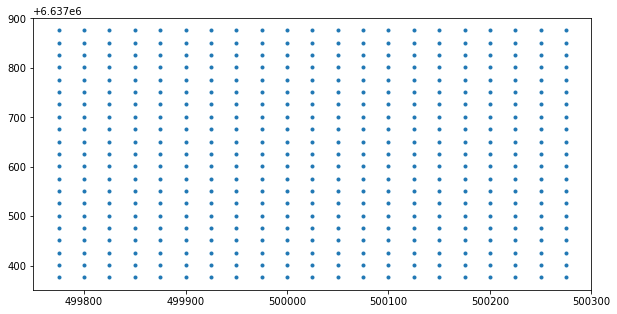

In [4]:
fig,axs = plt.subplots(figsize = (10,5))
axs.plot(head['CDP_X'],head['CDP_Y'],linewidth = 0,marker='.')

In [5]:
xline_size = head['XLINE'].values.max() - head['XLINE'].values.min()
yline_size = head['INLINE'].values.max() - head['INLINE'].values.min()
data_cube = data.reshape((xline_size + 1, yline_size + 1, data.shape[0]))

In [6]:
from matplotlib.pyplot import draw
%matplotlib inline

def explore_cube(data_cube, head):
    inlines_count, xlines_count = data_cube.shape[:-1]
    inline_min = head['INLINE'].min()
    xline_min = head['XLINE'].min()

    tw = widgets.ToggleButtons(
        options=['INLINE', 'XLINE'],
        description='DIM:',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
    )
    
    @widgets.interact(inline=(0, inlines_count - 1), xline=(0, xlines_count - 1), w = tw)
    def show_cube(inline, xline, w):
        fig, axs = plt.subplots(1, 2, figsize = (24,7), gridspec_kw={'width_ratios': [3, 1]})
        if w == 'INLINE':
            sub_head = head[head[w] == inline_min + inline] 
            to_show = data_cube[inline, :, :]
        else:
            sub_head = head[head[w] == xline_min + xline] 
            to_show = data_cube[xline, :, :]

        cdp_x_active = sub_head['CDP_X']
        cdp_y_active = sub_head['CDP_Y']
        axs[0].imshow(to_show, cmap='seismic', aspect='auto')
        axs[1].plot(head['CDP_X'], head['CDP_Y'], 'b.')
        axs[1].plot(cdp_x_active, cdp_y_active, 'r*')
        plt.show()
    return show_cube
explore_cube(data_cube, head)

interactive(children=(IntSlider(value=10, description='inline', max=20), IntSlider(value=10, description='xlin…

<function __main__.explore_cube.<locals>.show_cube(inline, xline, w)>